In [1]:
import warnings
from timeit import default_timer
from datetime import timedelta
from multiprocessing import Pool

import numpy as np  

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from urllib.parse import quote_plus

from deblib.constants import G, h, c, k_B
from deblib.vmath import exp


from dust_extinction.parameter_averages import F99, F04, G23
from dustmaps import config, bayestar
from pyvo import registry, DALServiceError

import emcee
from emcee.autocorr import AutocorrError
import corner

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load our MIST Isochrones and NewEra model spectra

In [2]:
from libs.mistisochrones import MistIsochrones
mist_isochrones = MistIsochrones(metallicities=[0])

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


In [3]:
# Load the Z==0 table created by parse_newera_spectra.py (either from numpy.save or pkl.dump)
ne_table = np.load("libs/data/newera/PHOENIX-NewEra-LR.Z-0.0.npy", allow_pickle=True)

count_spec = len(ne_table)
teff_from, teff_to = ne_table["teff"].min(), ne_table["teff"].max()
logg_from, logg_to = ne_table["logg"].min(), ne_table["logg"].max()
print(f"Loaded previously built, Z=0 NewEra spectra table containing {count_spec} spectra")
print(f"covering Teff from {teff_from} to {teff_to} K and logg from {logg_from} to {logg_to} dex")

Loaded previously built, Z=0 NewEra spectra table containing 852 spectra
covering Teff from 2300.0 to 12000.0 K and logg from 0.0 to 6.0 dex


### Set up our extinction model

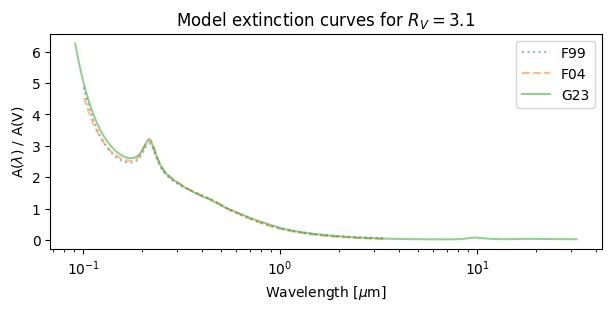

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)

### Select our target and get its known information

In [5]:
search_term = target = "V* CW Eri"
target_coords = SkyCoord(45.99980203 * u.deg, -17.73779498 * u.deg, 191.7 * u.pc, frame="icrs")

k, k_err = 0.703448, 0.000605       # from LC fitting
J, J_err = 0.929822, 0.002874       # from LC fitting
qphot = 0.836                       # from LC fitting
Ebv, Ebv_err = 0.013, 0.015         # from Rediscussion 17

# Known Teffs & masses from literature
known_teff1 = 6839 # +/- 87
known_teff2 = 5661 # +/- 98
known_M1 = 1.568 # +/- 0.016
known_M2 = 1.314 # +/- 0.010
known_age = 9.23 # log10(1.7 Gyr)

init_M1 = 1.5                       # M_sun
init_M2 = 1.3                       # M_sun
init_age = 9.0                      # log(age)

In [6]:
# search_term = target = "V* ZZ UMa"
# target_coords = SkyCoord("10h30m03.1946894976", "+61d48m41.430038256", 180.2 * u.pc, frame="icrs")

# k, k_err = 0.747898, 0.031343       # from LC fitting
# J, J_err = 0.633319, 0.027377       # from LC fitting
# qphot = 0
# Ebv, Ebv_err = 0.0, 0.01            # from Rediscussion 11

# # Known Teffs and masses from literature
# known_teff1 = 5960 # +/- 70
# known_teff2 = 5270 # +/- 90
# known_M1 = 1.1348 # +/- 0.0087
# known_M2 = 0.9652 # +/- 0.0051
# known_age = 9.74 # log10(5.5 Gyr)

# init_M1 = 1.1                       # M_sun
# init_M2 = 1.0                       # M_sun
# init_age = 9.7                      # log(age)

In [7]:
# search_term = target = "V* MU Cas"
# target_coords = SkyCoord("00h15m51.5603463336", "+60d25m53.642838468", 1948 * u.pc, frame="icrs")

# k, k_err = 0.864, 0.026             # from LC fitting
# J, J_err = 1.017, 0.013             # from LC fitting
# qphot = 0.981                       # published
# Ebv, Ebv_err = 0.50, 0.08           # from Rediscussion 22 & STILISM

# # Known Teffs and masses from Rediscussion 22
# known_teff1 = 14870 # +/- 500
# known_teff2 = 14940 # +/- 500
# known_M1 = 4.674    # +/- 0.091
# known_M2 = 4.586    # +/- 0.084
# known_age = 7.94    # log10(87 +/- 5 Myr)

# init_M1 = 4.7                       # M_sun
# init_M2 = 4.6                       # M_sun
# init_age = 8.0                      # log(age)

In [8]:
# search_term = target = "V* RR Lyn"
# target_coords = SkyCoord("06h26m25.8366305040", "+56d17m06.346261104", 80.5 * u.pc, frame="icrs")

# k, k_err = 0.627, 0.002             # from LC fitting
# J, J_err = 0.818, 0.007             # from LC fitting
# qphot = 0.779                       # published
# Ebv, Ebv_err = 0.002, 0.002         # from Rediscussion 7 & STILISM

# # Known Teffs and masses from Rediscussion 7
# known_teff1 = 7770  # +/- 200
# known_teff2 = 7180  # +/- 200
# known_M1 = 1.939    # +/- 0.007
# known_M2 = 1.510    # +/- 0.003
# known_age = 8.98    # log(950 +/- 20 Myr)

# init_M1 = 2.0                       # M_sun
# init_M2 = 1.5                       # M_sun
# init_age = 9.0                      # log(age)

### Get the SED data for the target
- apply default uncertainties to those measurements with none
- exclude measurements outside the range of our extinction model
- exclude outliers

In [9]:
sed = Table.read(f"https://vizier.cds.unistra.fr/viz-bin/sed?-c={quote_plus(search_term)}&-c.rs=0.1")
sed.sort(["sed_freq"], reverse=True)

In [10]:
# Scalar values for the data to be sampled
sed_freq = sed["sed_freq"].to(u.Hz).value
sed_lambda = np.divide(c * u.m / u.s, sed_freq * u.Hz).to(u.um).value
sed_flux = sed["sed_flux"].to(u.W / (u.m**2 * u.Hz)).value
sed_eflux = sed["sed_eflux"].to(u.W / (u.m**2 * u.Hz)).value

In [11]:
# Apply error bars where none recorded (10% uncertainty)
np.nan_to_num(sed_eflux, copy=False, nan=0)
no_err_mask = sed_eflux == 0
sed_eflux[no_err_mask] = sed_flux[no_err_mask] / 10

In [12]:
# filter so we only use measurements covered by our extinction model
ext_model_range = np.reciprocal(ext_model.x_range) # x_range has implicit units of 1/micron
ext_mask = (sed_lambda > min(ext_model_range)) & (sed_lambda < max(ext_model_range))

# and additionally filter to ensure measurements within our atmosphere models.
#ext_mask &= (sed_lambda > ne_table['lam_from'].max()) & (sed_lambda < ne_table['lam_to'].min())

# Find outliers to mask
out_mask = np.array([False] * len(sed_lambda))
if "CW Eri" in target:
    out_mask |= sed["sed_filter"] == "Cousins:I"

# These tend to give outliers at ~0.402 um
out_mask |= sed["sed_filter"] == "HIP:Hp"

sed_lambda = sed_lambda[ext_mask & ~out_mask]
sed_freq = sed_freq[ext_mask & ~out_mask]
sed_flux = sed_flux[ext_mask & ~out_mask]
sed_eflux = sed_eflux[ext_mask & ~out_mask]

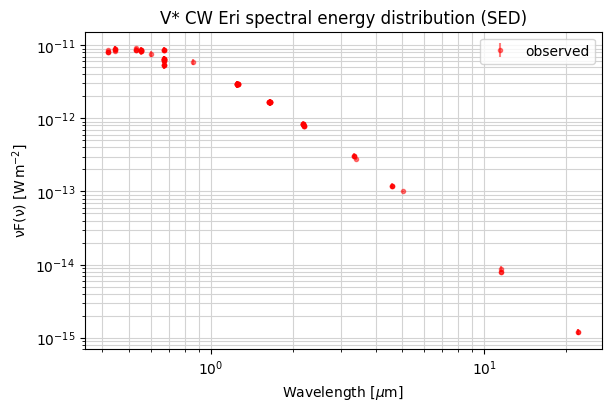

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed_lambda, sed_flux*sed_freq, sed_eflux*sed_freq, fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)", xlabel=r"Wavelength [$\mu$m]",
       ylabel=r"${\rm \nu F(\nu)}$ [${\rm W\,m^{-2}}$]", xscale="log", yscale="log")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED

In [14]:
from requests.exceptions import HTTPError
try:
    # Creates/confirms local cache of Bayestar data within the .cache directory
    config.config['data_dir'] = '.cache/.dustmapsrc'
    bayestar.fetch(version="bayestar2019")
except HTTPError as exc:
    print(f"Failed to (re)fetch data: {exc}")

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [15]:
query = bayestar.BayestarQuery(version='bayestar2019')
Ebv, _flags = query(target_coords, mode='median', return_flags=True)

# Relations from Bayestar 17 or 19 to E(B-V) documented at http://argonaut.skymaps.info/usage
# as E(B-V) = 0.884*bayestar or E(B-V) = 0.996*bayestar
Ebv *= 0.996
print(f'For {target} the {query.__class__.__name__} extinction is: E(B-V) = {Ebv:.6f} mag',
       '\n( diagnostic flags:', ', '.join(f'{n} = {_flags[n]}' for n in _flags.dtype.names), ')') 

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.438 s
  pix_info:   0.350 s
   samples:  14.221 s
      best:   2.860 s
       nan:   0.028 s
      sort:   7.904 s
       idx:   0.075 s
For V* CW Eri the BayestarQuery extinction is: E(B-V) = 0.009960 mag 
( diagnostic flags: converged = True, reliable_dist = False )


In [16]:
Av = None
if not Ebv:
    try:
        # Extinction map of Vergely, Lallement & Cox (2022)
        # TODO: anything extra to map these values to Av?
        ivoid = 'ivo://CDS.VizieR/J/A+A/664/A174'
        table = 'J/A+A/664/A174/cube_ext'
        vo_res = registry.search(ivoid=ivoid)[0]
        print(f'Querying {vo_res.res_title} ({vo_res.source_value}) for extinction data...')

        for _res in [10, 50]: # central regions at 10 pc resolution and outer at 50 pc
            _cart = np.round(target_coords.cartesian.xyz.to(u.pc) / _res) * _res
            _rec = vo_res.get_service('tap').search(f'SELECT * FROM "{table}" ' + 
                f'WHERE x={_cart[0].value:.0f} AND y={_cart[1].value:.0f} AND z={_cart[2].value:.0f}''')
            if len(_rec):
                ext_nmag_per_pc = _rec["Exti"][0]
                Av = (ext_nmag_per_pc * target_coords.distance.to(u.pc).value) / 10**9
                print(f"For {target} the nearest extinction value is: Av={Av:.6f}")
                break
    except DALServiceError as exc:
        print(f"Failed to query: {exc}")

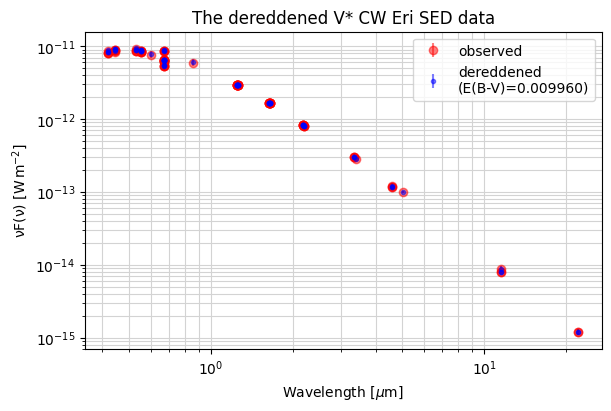

In [17]:
# extinguish calcs extinction as a factor, so dividing by it will de-redden
if Ebv: # Prefer the Ebv from Bayestar
    sed_der_flux = sed_flux / ext_model.extinguish(sed_lambda * u.um, Ebv=Ebv)
    der_lab = f"dereddened\n(E(B-V)={Ebv:.6f})"
elif Av:
    sed_der_flux = sed_flux / ext_model.extinguish(sed_lambda * u.um, Av=Av)
    der_lab = f"dereddened\n($A_v={Av:.6f}$)"
else:
    print(f"!!!No de-reddening found!!!")
    sed_der_flux = sed_flux
    der_lab = "not dereddened"

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed_lambda, sed_flux*sed_freq, sed_eflux*sed_freq, fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed_lambda, sed_der_flux*sed_freq, sed_eflux*sed_freq, fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data", xlabel=r"Wavelength [$\mu$m]",
       ylabel=r"${\rm \nu F(\nu)}$ [${\rm W\,m^{-2}}$]", xscale="log", yscale="log")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the MCMC functions

#### Model the combined spectrum based on the Planck blackbody function

In [18]:
def bb_spectral_brightness(teff, nu):
    """
    Calculate the BB spectral brightness at effective temp T and frequencies v with;
    B(v, T) = (2hv^3)/c^2 * 1/(exp(hv/kT)-1)  [W / m^2 / Hz / sr]

    Params teff and nu are floats in units of K and Hz, respectively
    """
    pt1 = (2 * h * nu**3) / c**2
    pt2 = exp((h * nu) / (k_B * teff)) - 1
    return pt1 / pt2

#### Model the combined spectrum based on NewEra stellar atmosphere models

In [19]:
def newera_spectrum(teff, logg, nu):
    # Find the rows with the nearest Teff
    teff_best_diff = ne_table[np.argmin(np.abs(ne_table["teff"]-teff))]["teff"] - teff
    teff_mask = (ne_table["teff"]+teff_best_diff == teff) | (ne_table["teff"]-teff_best_diff == teff)

    # And select the row with the nearest logg
    row = ne_table[teff_mask][np.argmin(np.abs(ne_table[teff_mask]["logg"]-logg))]
    return row["flux_interp"](nu)

In [20]:
def model(x, Teff1, Teff2, logg1, logg2):
    return ( bb_spectral_brightness(Teff1, x), bb_spectral_brightness(Teff2, x) )
    #return ( newera_spectrum(Teff1, logg1, x), newera_spectrum(Teff2, logg2, x) )

#### The MCMC functions
- `lnlike` is the _likelihood function_ which compares the model spectra with the observed data (both normalized)
- `lnprior` contains any _prior knowledge_ we have about the parameters from elsewhere
  - in this case there are restrictions on stellar age/phase and a known ratio of radii from LC fitting
  - also returns a blob containing the two stars' $T_{\rm eff}$ and $\log{g}$ values for masses and age being sampled
- `lnprob` combines the two into a probability density

In [21]:
def lnlike(x, y, y_err, Teff1, Teff2, logg1, logg2):
    # Compare both in min-max normalized form (y is already normalized)
    y_model = np.add(*model(x, Teff1, Teff2, logg1, logg2))
    y_min = y_model.min()
    y_model_norm = (y_model - y_min) / (y_model.max() - y_min)
    return -0.5 * np.sum(((y - y_model_norm) / y_err)**2)

In [22]:
MIN_MASS, MAX_MASS = 0.4, 290       # mass range in MIST data
MIN_AGE, MAX_AGE = 5.0, 10.3        # log(age) range in MIST data
MIN_PHASE, MAX_PHASE = 0.0, 2.0     # MIST main sequence to RGB phases
MIST_PARAMS = ["Teff", "log_g", "R", "phase"]

def lnprior(M1, M2, log_age, k):
    Teff1, Teff2, logg1, logg2 = None, None, None, None

    # Basic validation of priors; lookup won't work if these are out of range of MIST values
    if is_valid := (MIN_MASS <= M1 <= MAX_MASS and MIN_MASS <= M2 <= MAX_MASS and MIN_AGE <= log_age <= MAX_AGE):
        # Get the T_eff values which we need to generate a SED and to validate the parameters
        try:
            Teff1, logg1, R1, phase1 = mist_isochrones.stellar_params_for_lookup(0, log_age, "star_mass", M1, MIST_PARAMS)
            Teff2, logg2, R2, phase2 = mist_isochrones.stellar_params_for_lookup(0, log_age, "star_mass", M2, MIST_PARAMS)
            is_valid = np.abs((R2/R1) - k) < 0.1 \
                        and min(phase1, phase2) >= MIN_PHASE \
                        and max(phase1, phase2) <= MAX_PHASE
        except ValueError:
            is_valid = False

    return 0.0 if is_valid else -np.inf, (Teff1, Teff2, logg1, logg2)

In [23]:
def lnprob(theta, x, y, y_err, k):
    M1, M2, log_age = theta
    lp, blob = lnprior(M1, M2, log_age, k)
    if not np.isfinite(lp):
        return -np.inf, blob
    Teff1, Teff2 = blob[0], blob[1]
    logg1, logg2 = blob[2], blob[3]
    return lp + lnlike(x, y, y_err, Teff1, Teff2, logg1, logg2), blob

#### Run the MCMC

In [24]:
nwalkers = 100
niters = 100000
SEED = 42
rng = np.random.default_rng(SEED)

# Starting position for the search - derived from approximations used in LC fitting
print(f"Starting point:\nM1 = {init_M1:.3f} M_sun\nM2 = {init_M2:.3f} M_sun\nlog(age) = {init_age}")
initial = np.array([init_M1, init_M2, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, 0.1, ndim) for _ in range(nwalkers)]

# min-max normalize the de-reddened observed flux
_norm_scale = sed_der_flux.max() - sed_der_flux.min()
sed_norm_flux = (sed_der_flux - sed_der_flux.min()) / _norm_scale
sed_norm_eflux = sed_eflux / _norm_scale

Starting point:
M1 = 1.500 M_sun
M2 = 1.300 M_sun
log(age) = 9.0


In [25]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")

    with Pool() as pool:
        lnprob_kwargs = { "x": sed_freq, "y": sed_norm_flux, "y_err": sed_norm_eflux, "k": k }
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=lnprob, kwargs=lnprob_kwargs, pool=pool)

        print(f"Running MCMC for {niters} iterations...")
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 100000 iterations...


100%|██████████| 100000/100000 [16:00<00:00, 104.08it/s]


In [26]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

try:
    # autocorrelation time; steps to effectively "forget" start position
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau

Mean Acceptance fraction: 0.403789


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Autocorrelation steps:    nan, nan, nan


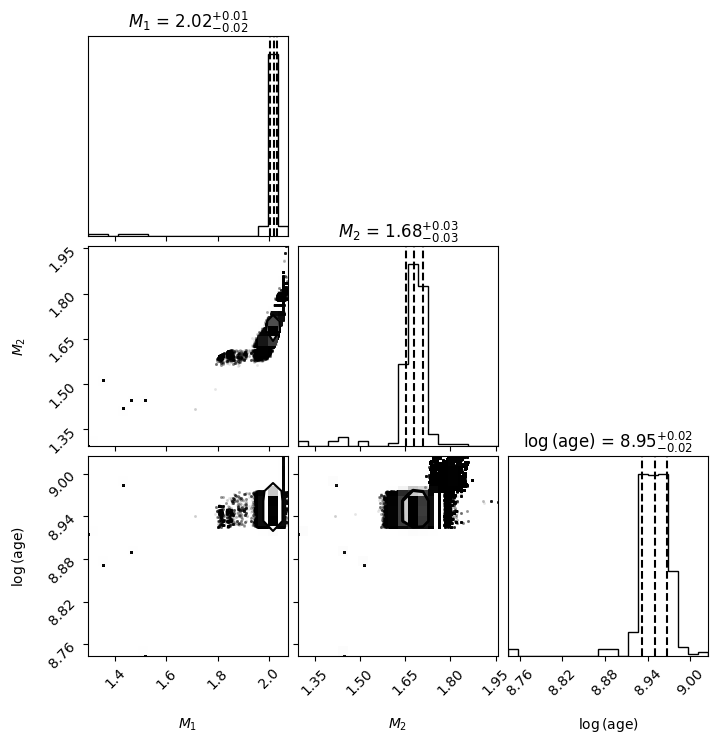

In [27]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
labels = [r"$M_{\rm 1}$", r"$M_{\rm 2}$", r"$\log{({\rm age})}$"]
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

In [28]:
# Gets the median fitted values (currently M1, M2 and log(age))
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)

for ix, (var, known) in enumerate([("M1", known_M1), ("M2", known_M2), ("log(age)", known_age)]):
    print(f"{var:>9s} = {fitted_vals[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f}",
          f"(known value {known:.3f})")

       M1 = 2.018 +/- 0.012/0.016 (known value 1.568)
       M2 = 1.679 +/- 0.031/0.027 (known value 1.314)
 log(age) = 8.950 +/- 0.018/0.018 (known value 9.230)


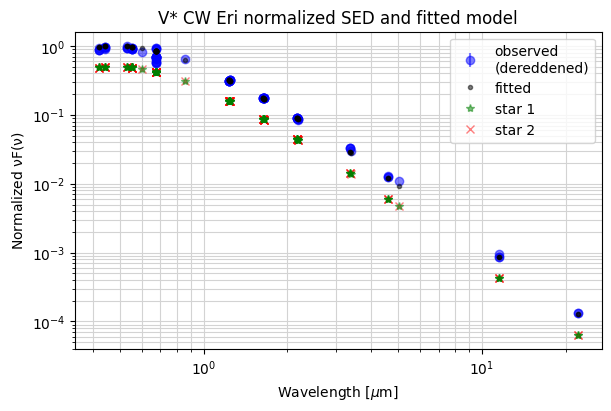

In [29]:
# Need to get the effective temperatures & logg for these masses/age combinations
M1, M2, log_age = fitted_vals
teff1, logg1 = mist_isochrones.stellar_params_for_lookup(0, log_age, "star_mass", M1, ["Teff", "log_g"])
teff2, logg2 = mist_isochrones.stellar_params_for_lookup(0, log_age, "star_mass", M2, ["Teff", "log_g"])

# Generate a model SED from the fitted values for plotting
mod_star_vfv = model(sed_freq, teff1, teff2, logg1, logg2) * sed_freq
mod_comb_vfv = np.add(*model(sed_freq, teff1, teff2, logg1, logg2)) * sed_freq
mod_norm_scale = mod_comb_vfv.max() - mod_comb_vfv.min()

sed_vfv, sed_evfv = sed_flux * sed_freq, sed_eflux * sed_freq
sed_norm_scale = sed_vfv.max() - sed_vfv.min()

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,              eflux,      norm_scale,         fmt,    z,      label) in [
    (sed_lambda,    sed_vfv,           sed_evfv,   sed_norm_scale,     "ob",   10,     "observed\n(dereddened)"),
    (sed_lambda,    mod_comb_vfv,      None,       mod_norm_scale,     ".k",   40,     "fitted"),
    (sed_lambda,    mod_star_vfv[0],   None,       mod_norm_scale,     "*g",   30,     "star 1"),
    (sed_lambda,    mod_star_vfv[1],   None,       mod_norm_scale,     "xr",   20,     "star 2"),
]:
    # Rather than (flux-min(flux))/norm_scale we plot flux/norm_scale so that we don't loose the lowest value to zero
    ax.errorbar(lam, (flux)/norm_scale, eflux, fmt=fmt, alpha=0.5, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$", xscale="log", yscale="log")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)